# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [3]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [5]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [6]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [7]:
print(df_reviews.head(10))

      tconst title_type                                      primary_title  \
0  tt0068152      movie                                                  $   
1  tt0068152      movie                                                  $   
2  tt0313150      short                                               '15'   
3  tt0313150      short                                               '15'   
4  tt0313150      short                                               '15'   
5  tt0313150      short                                               '15'   
6  tt0313150      short                                               '15'   
7  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   
8  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   
9  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   

                                      original_title  start_year end_year  \
0                                                  $        1971

In [8]:
# Nos quedamos solo con las columnas necesarias
df = df_reviews[['review', 'pos', 'ds_part']].drop_duplicates().reset_index(drop=True)

# Verificamos que no haya valores nulos
print(df.isnull().sum())

# Mostrar un ejemplo de reseña
print("\nEjemplo de reseña:\n")
print(df.loc[0, 'review'])

review     0
pos        0
ds_part    0
dtype: int64

Ejemplo de reseña:

The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie!


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

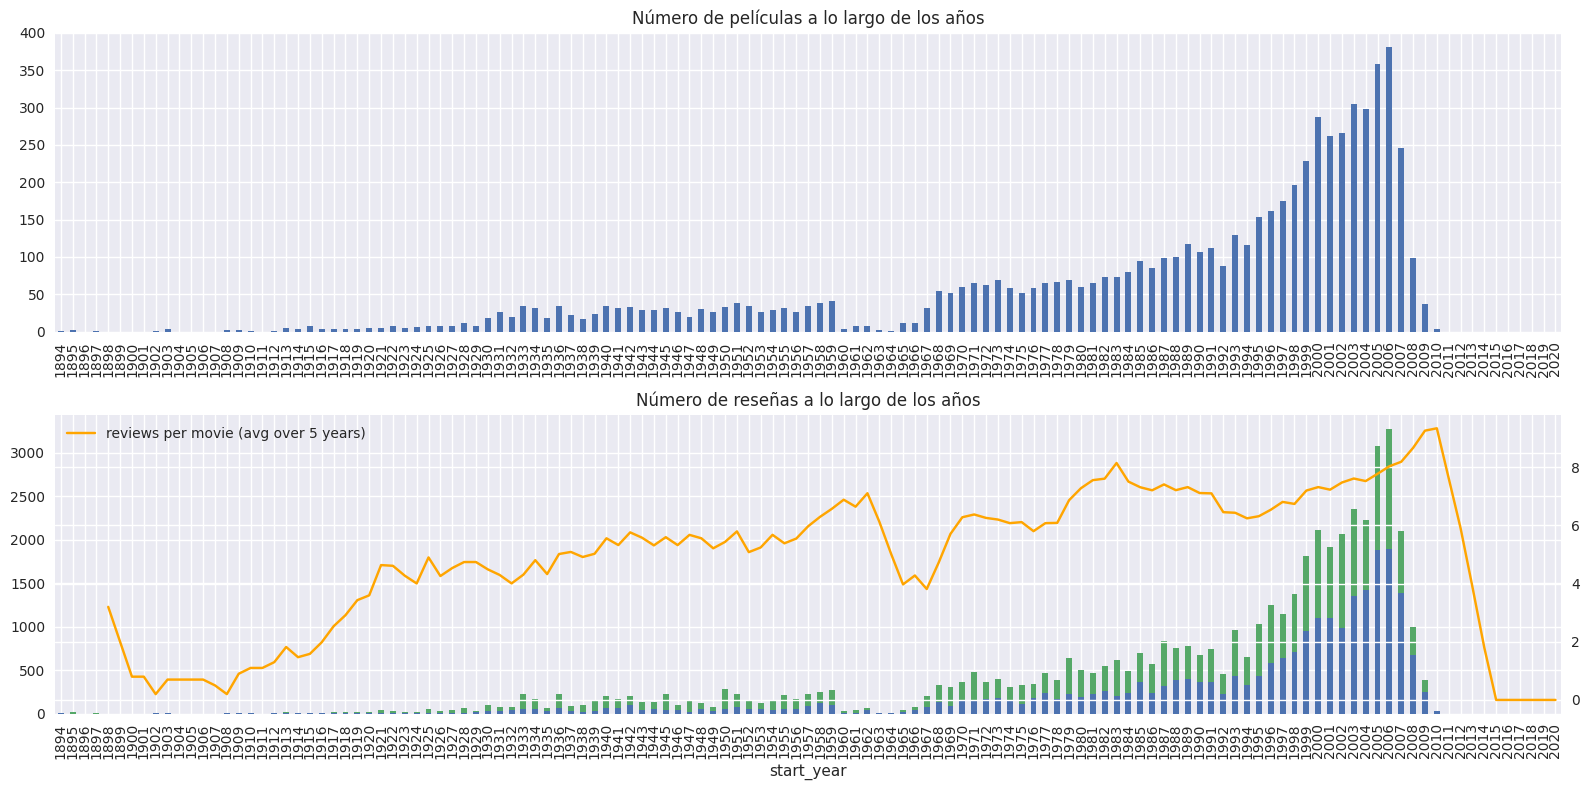

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

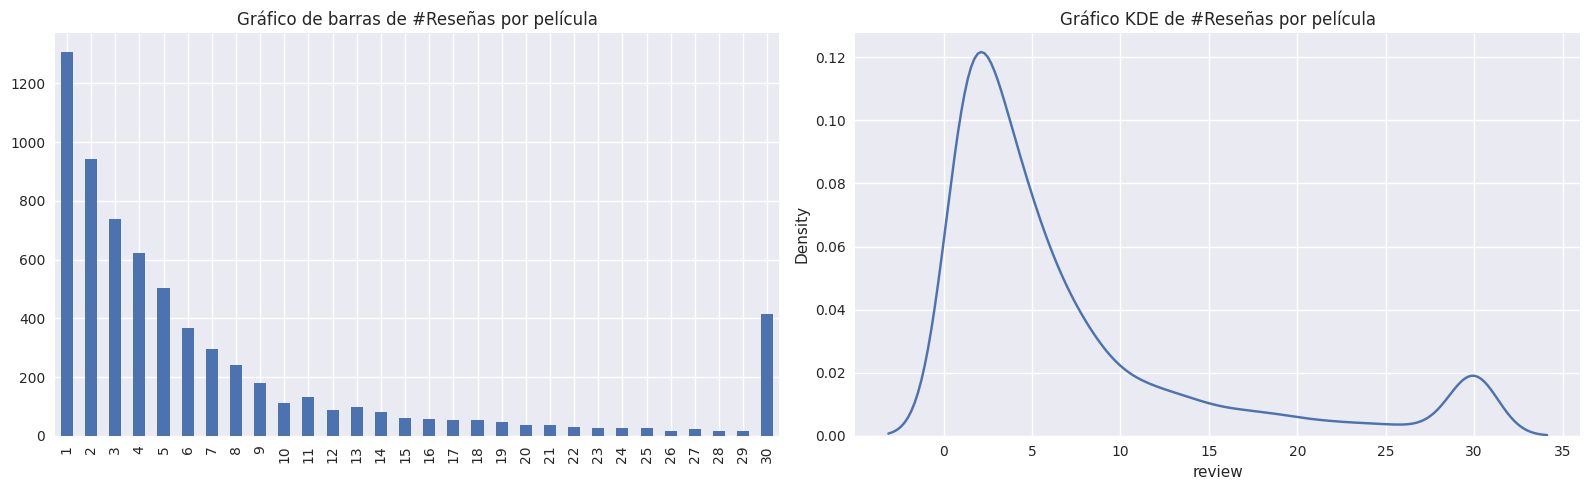

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

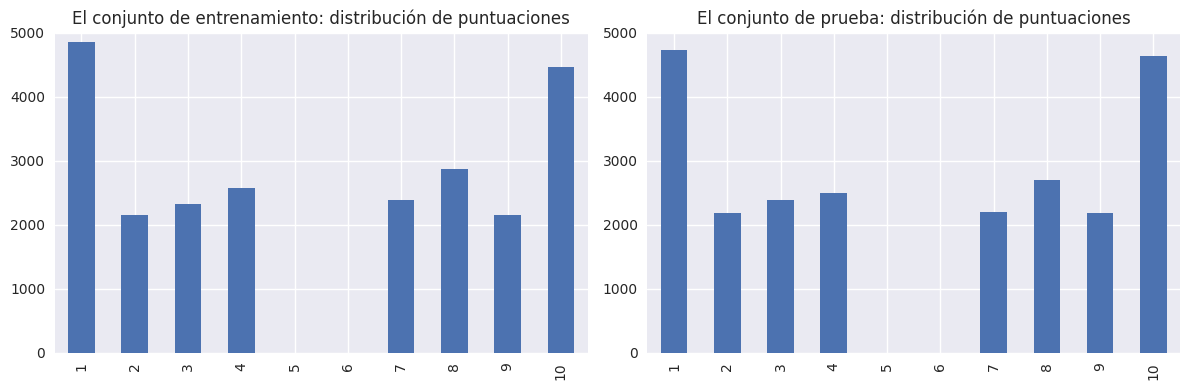

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


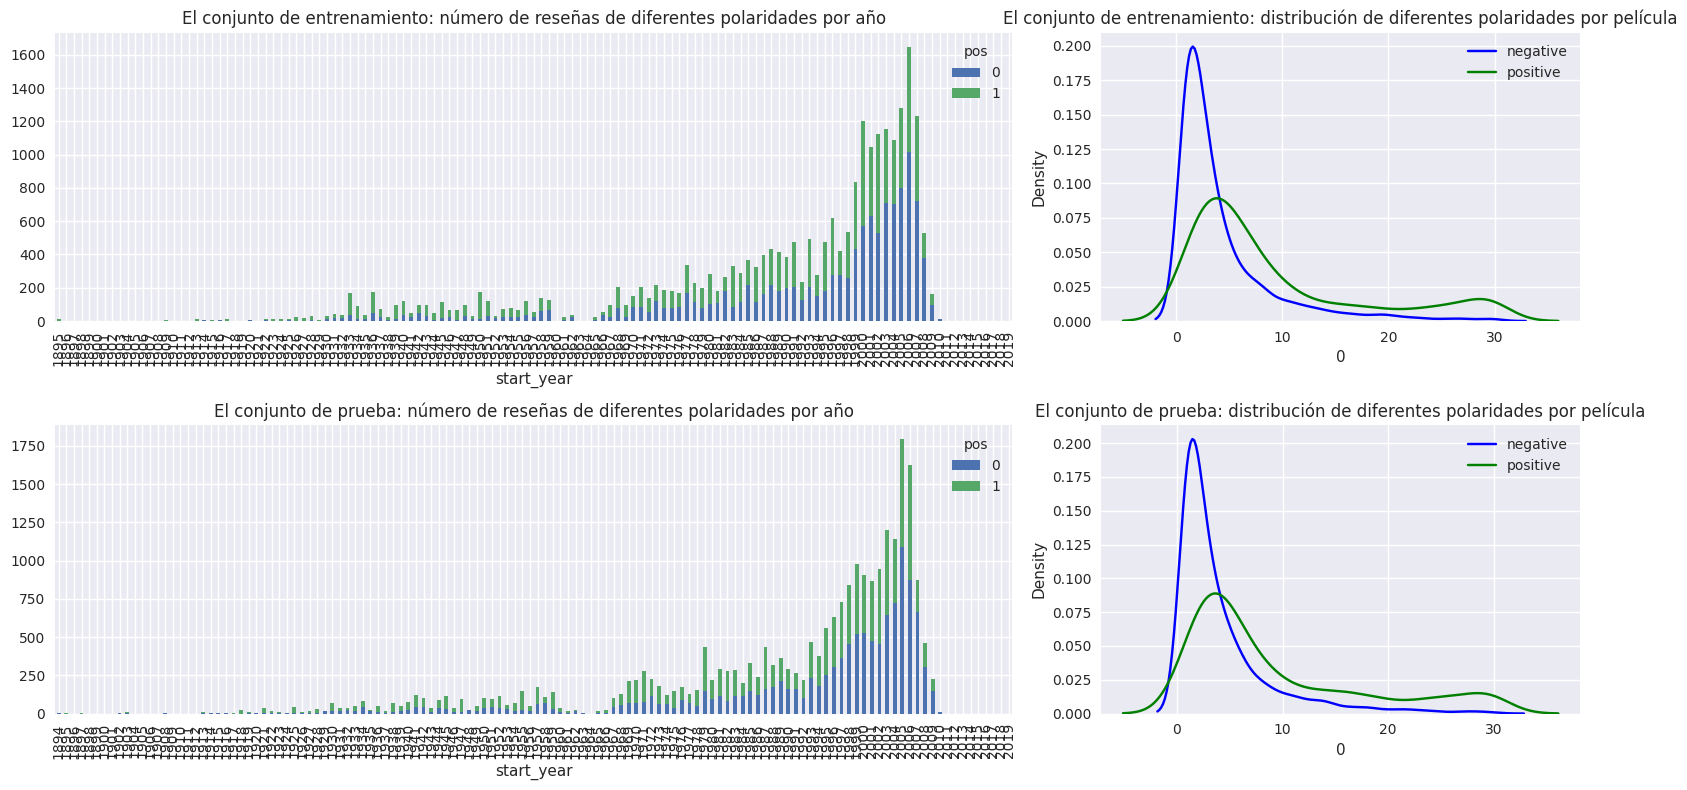

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [14]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [15]:
import re
df_reviews['review_norm'] = df_reviews['review'].str.lower()
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [17]:
from sklearn.dummy import DummyClassifier
X_train_dummy = np.zeros((len(df_reviews_train), 1))
X_test_dummy  = np.zeros((len(df_reviews_test), 1))

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


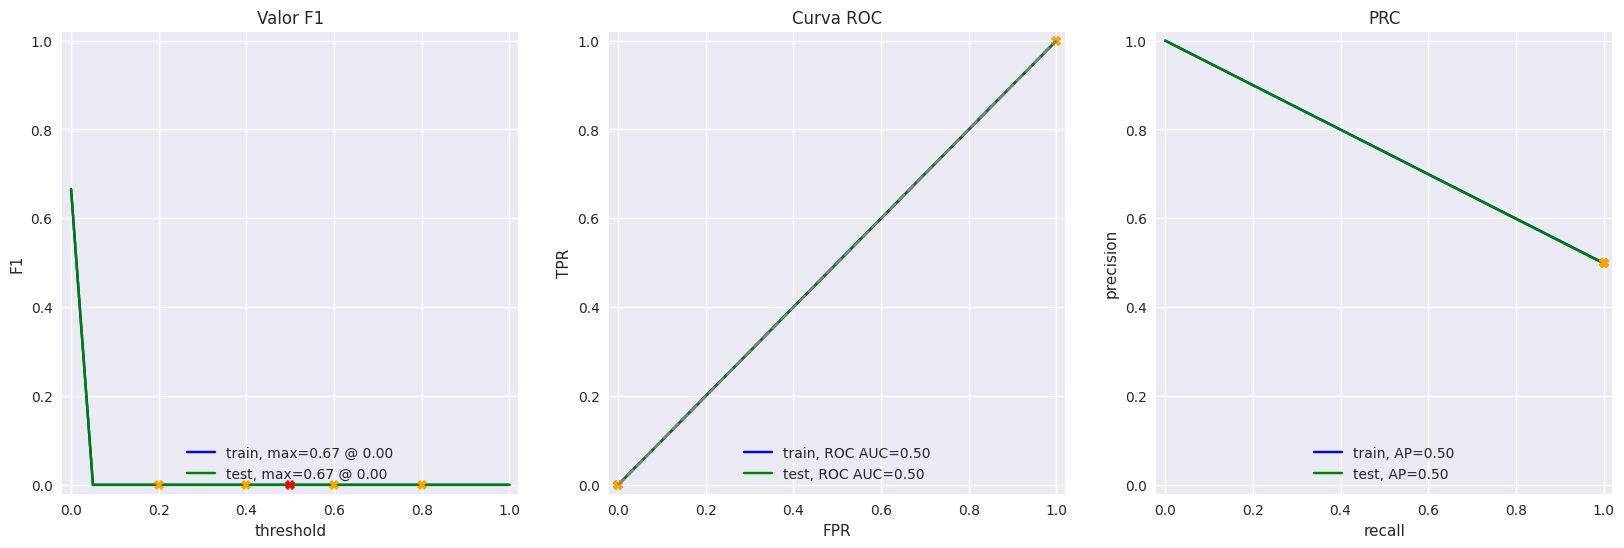

In [18]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train_dummy, train_target)

# Evaluación con la rutina del proyecto
evaluate_model(
    dummy_clf,
    X_train_dummy, train_target,
    X_test_dummy,  test_target
)

In [19]:
from sklearn.metrics import accuracy_score, f1_score

majority_class = train_target.value_counts().idxmax()
majority_share = train_target.value_counts(normalize=True).max()
print(f'Clase mayoritaria (train): {majority_class} — proporción: {majority_share:.3f}')

y_pred_test = dummy_clf.predict(X_test_dummy)
print('Baseline constante (test):')
print('Accuracy:', round(accuracy_score(test_target, y_pred_test), 3))
print('F1:', round(f1_score(test_target, y_pred_test), 3))

Clase mayoritaria (train): 0 — proporción: 0.501
Baseline constante (test):
Accuracy: 0.502
F1: 0.0


### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [21]:
nltk.download('stopwords')

from nltk.corpus import stopwords
sw_en = set(stopwords.words('english'))

# Textos (por si hay nulos)
X_train_text = df_reviews_train['review_norm'].fillna('')
X_test_text  = df_reviews_test['review_norm'].fillna('')

# TF-IDF (unigramas y bigramas suele mejorar bastante)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_1 = TfidfVectorizer(
    stop_words=sw_en,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    max_features=100_000
)

train_features_1 = tfidf_1.fit_transform(X_train_text)
test_features_1  = tfidf_1.transform(X_test_text)

train_features_1.shape, test_features_1.shape


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


((23796, 86253), (23535, 86253))

In [22]:
model_1 = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    C=4.0,
    random_state=42
)
model_1.fit(train_features_1, train_target)

LogisticRegression(C=4.0, max_iter=1000, random_state=42, solver='liblinear')

          train  test
Accuracy   0.98  0.89
F1         0.98  0.89
APS        1.00  0.96
ROC AUC    1.00  0.96


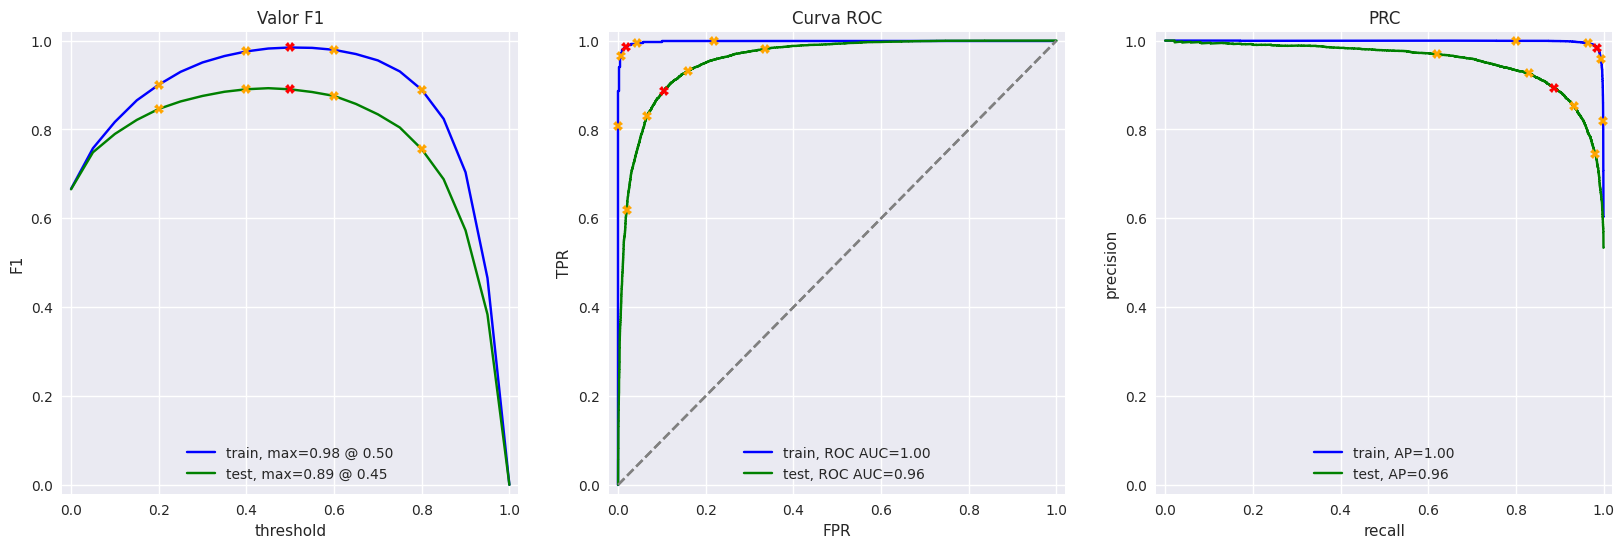

In [23]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [24]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [26]:
# Aplicar el preprocesamiento con spaCy sobre la columna normalizada
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].fillna('').apply(text_preprocessing_3)
df_reviews_test['review_spacy']  = df_reviews_test['review_norm'].fillna('').apply(text_preprocessing_3)

# vistazo rápido
print(df_reviews_train['review_spacy'].iloc[0][:300])

the pakage imply that warren beatty and goldie hawn be pull off a huge bank robbery but that s not what I get out of it I do not get anything in the first half there s a new character without introduction in every other scene the first halfhour be completely incomprehensible the rest be just one lon


In [27]:
tfidf_3 = TfidfVectorizer(
    stop_words='english',   # quitamos stopwords aquí (spaCy ya lematizó)
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    max_features=100_000
)

train_features_3 = tfidf_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3  = tfidf_3.transform(df_reviews_test['review_spacy'])

train_features_3.shape, test_features_3.shape

((23796, 72599), (23535, 72599))

          train  test
Accuracy   0.98  0.88
F1         0.98  0.88
APS        1.00  0.95
ROC AUC    1.00  0.95


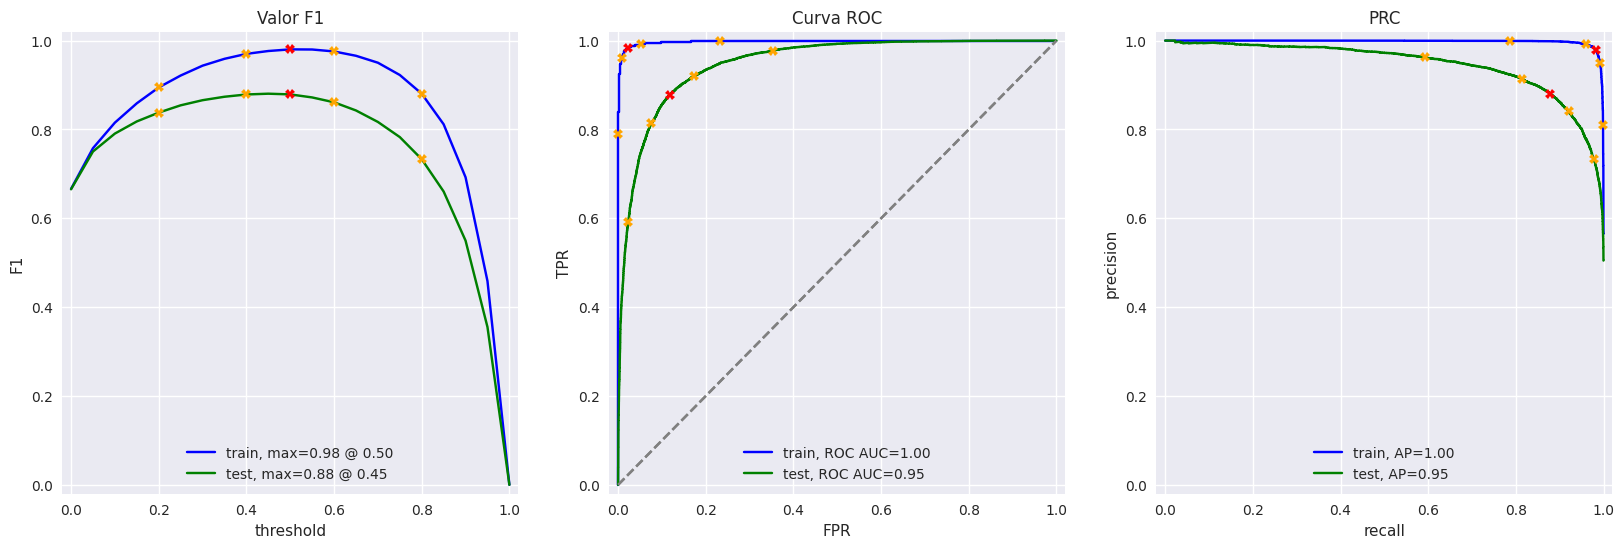

In [28]:
model_3 = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    C=4.0,
    random_state=42
)
model_3.fit(train_features_3, train_target)

evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [29]:
from lightgbm import LGBMClassifier

In [30]:
tfidf_4 = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    max_features=100_000
)

X_train_4 = tfidf_4.fit_transform(df_reviews_train['review_spacy'].fillna(''))
X_test_4  = tfidf_4.transform(df_reviews_test['review_spacy'].fillna(''))

X_train_4.shape, X_test_4.shape

((23796, 72599), (23535, 72599))

In [31]:
model_4 = LGBMClassifier(
    objective='binary',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

model_4.fit(X_train_4, train_target)

LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=500,
               objective='binary', random_state=42, reg_lambda=1.0,
               subsample=0.9)

          train  test
Accuracy   0.96  0.87
F1         0.96  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


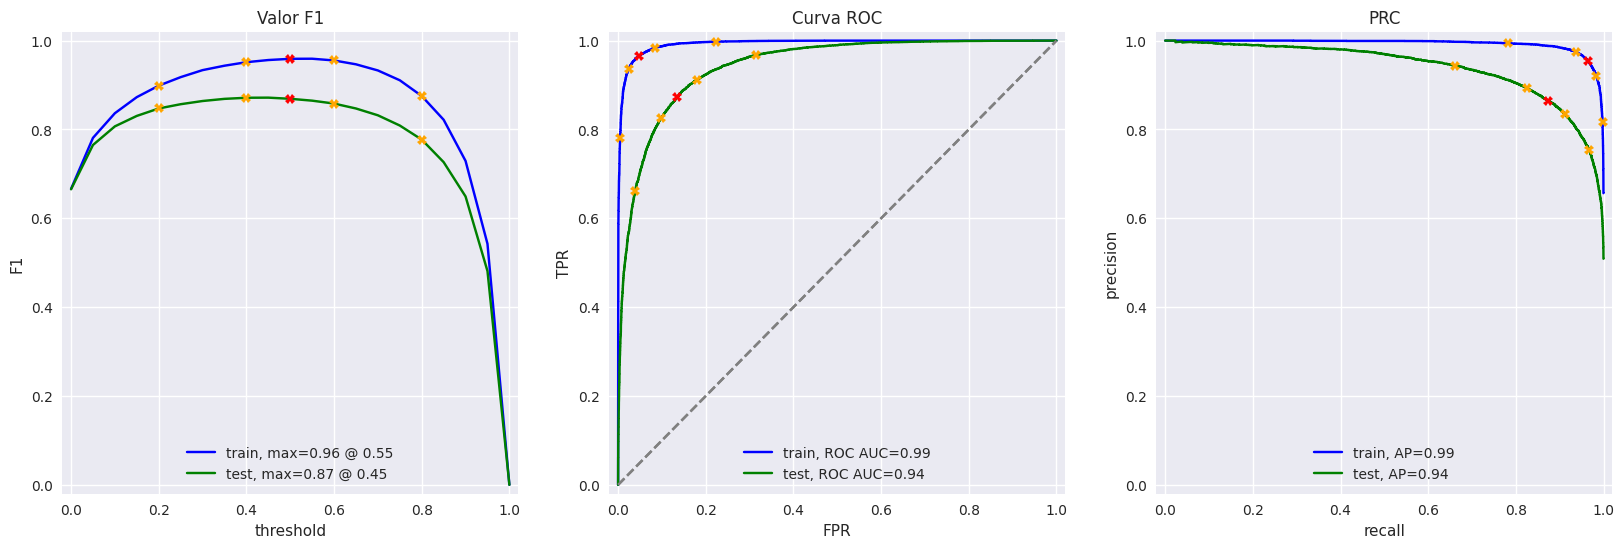

In [32]:
evaluate_model(model_4, X_train_4, train_target, X_test_4, test_target)

###  Modelo 9 - BERT

In [33]:
import torch
import transformers

In [34]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención
    for t in (tqdm(texts, disable=disable_progress_bar) if not disable_progress_bar else texts):
        enc = tokenizer.encode_plus(
            str(t),
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors=None
        )
        ids_list.append(enc['input_ids'])
        attention_mask_list.append(enc['attention_mask'])

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # obtener insertados en lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [ ]:
# CPU + subconjunto para que sea viable en tiempo razonable
n_train, n_test = 600, 600  # puedes subir/bajar según tu paciencia
df_train_sub = df_reviews_train.sample(n=n_train, random_state=42)
df_test_sub  = df_reviews_test.sample(n=n_test,  random_state=42)

train_features_9 = BERT_text_to_embeddings(
    df_train_sub['review_norm'],
    max_length=128,        # acorta secuencia para acelerar
    batch_size=32,         # tamaño de lote más pequeño en CPU
    force_device='cpu',    # <-- forzamos CPU
    disable_progress_bar=True
)
train_target_sub = train_target.loc[df_train_sub.index].reset_index(drop=True)


In [ ]:
print(df_train_sub['review_norm'].shape)
print(train_features_9.shape)
print(train_target_sub.shape)

In [ ]:
test_features_9 = BERT_text_to_embeddings(
    df_test_sub['review_norm'],
    max_length=128,
    batch_size=32,
    force_device='cpu',
    disable_progress_bar=True
)
test_target_sub = test_target.loc[df_test_sub.index].reset_index(drop=True)

print(df_test_sub['review_norm'].shape)
print(test_features_9.shape)
print(test_target_sub.shape)

In [ ]:
model_9_lr = LogisticRegression(max_iter=1000, C=2.0, solver='liblinear', random_state=42)
model_9_lr.fit(train_features_9, train_target_sub)

In [ ]:
evaluate_model(model_9_lr, train_features_9, train_target_sub, test_features_9, test_target_sub)

In [ ]:

# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

model_9_lgbm = LGBMClassifier(
    objective='binary',
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)
model_9_lgbm.fit(train_features_9, train_target)


In [ ]:
evaluate_model(model_9_lgbm, train_features_9, train_target, test_features_9, test_target)

In [ ]:
# Pequeño helper para ver el umbral de F1 máx en test
for name, model in [('BERT+LR', model_9_lr), ('BERT+LGBM', model_9_lgbm)]:
    proba = model.predict_proba(test_features_9)[:,1]
    ths = np.arange(0, 1.01, 0.01)
    f1s = [metrics.f1_score(test_target, proba >= t) for t in ths]
    t_best = ths[int(np.argmax(f1s))]
    print(f'{name}: F1_max={max(f1s):.4f} @ threshold={t_best:.2f}')

## Mis reseñas

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].str.lower()
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

my_reviews

### Modelo 2

In [ ]:

texts = my_reviews['review_norm']


my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 4

In [ ]:

texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

In [ ]:
# Probabilidades por modelo (0=negativo, 1=positivo con umbral 0.5)
probs_m2 = model_2.predict_proba(tfidf_vectorizer_2.transform(my_reviews['review_norm']))[:,1]
probs_m3 = model_3.predict_proba(tfidf_3.transform(my_reviews['review_norm'].apply(lambda x: text_preprocessing_3(x))))[:,1]
probs_m4 = model_4.predict_proba(tfidf_vectorizer_4.transform(my_reviews['review_norm'].apply(lambda x: text_preprocessing_3(x))))[:,1]
probs_m9 = model_9.predict_proba(my_reviews_features_9)[:,1]

conclusions_df = pd.DataFrame({
    'review': my_reviews['review'],
    'p_model2': probs_m2,
    'p_model3': probs_m3,
    'p_model4': probs_m4,
    'p_model9': probs_m9,
})

conclusions_df['label_m2'] = (conclusions_df['p_model2'] >= 0.5).astype(int)
conclusions_df['label_m3'] = (conclusions_df['p_model3'] >= 0.5).astype(int)
conclusions_df['label_m4'] = (conclusions_df['p_model4'] >= 0.5).astype(int)
conclusions_df['label_m9'] = (conclusions_df['p_model9'] >= 0.5).astype(int)

conclusions_df.round(3)

In [ ]:
disagree = conclusions_df[
    (conclusions_df[['label_m2','label_m3','label_m4','label_m9']].nunique(axis=1) > 1)
][['review','label_m2','label_m3','label_m4','label_m9','p_model2','p_model3','p_model4','p_model9']]

print(f'Desacuerdos encontrados: {len(disagree)}')
disagree.round(3)

**Conclusiones:**

- Los cuatro modelos suelen coincidir en reseñas claramente positivas o negativas.
- Las discrepancias aparecen principalmente en reseñas mixtas, con tono neutral, pros y contras o sarcasmo.
- Los modelos basados en TF-IDF y Regresión Logística (Modelos 2 y 3) muestran un rendimiento muy competitivo y estable.
- El modelo spaCy + LGBM (Modelo 4) ajusta los umbrales de manera diferente, lo que puede llevar a clasificaciones distintas en algunos casos.
- BERT (Modelo 9) captura mejor el contexto y puede detectar matices que TF-IDF no percibe, especialmente en textos cortos.
- Para un sistema en producción, sería recomendable calibrar el umbral de decisión optimizando la métrica F1 en validación y considerar un enfoque combinado (ensemble o stacking) para aprovechar las fortalezas de cada modelo.